# Advanced Analysis: Deep Dives and Smart Money Detection

This notebook contains advanced analyses that go beyond the core EDA, focusing on outlier detection, smart money identification, regime shifts, and dimensionality reduction. The goal is to uncover hidden patterns and actionable insights for trading strategy and risk management.

## Initial Preprocessing

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [95]:
# Load data (replace with your actual file path)
traders = pd.read_csv("csv_files/fear_greed_index.csv")
sentiment = pd.read_csv("csv_files/historical_data.csv")

In [96]:
# Standardizing column names for consistency
traders.columns = [col.lower().replace(' ', '_') for col in traders.columns]
sentiment.columns = [col.replace(' ', '_').replace('PnL', 'PnL').replace('ID', 'ID') for col in sentiment.columns]

In [97]:
# For historical_data.csv - convert 'Timestamp_IST' to proper datetime
sentiment['Timestamp_IST'] = pd.to_datetime(sentiment['Timestamp_IST'], format='%d-%m-%Y %H:%M')

# For fear_greed_index.csv - converting unix timestamp to datetime
traders['timestamp'] = pd.to_datetime(traders['timestamp'], unit='s')
traders['date'] = pd.to_datetime(traders['date'])

In [98]:
# Convert categorical columns to category type for memory efficiency
sentiment['Side'] = sentiment['Side'].astype('category')
sentiment['Direction'] = sentiment['Direction'].astype('category')
sentiment['Coin'] = sentiment['Coin'].astype('category')
traders['classification'] = traders['classification'].astype('category')

In [99]:
# Time-based features for temporal analysis
sentiment['hour'] = sentiment['Timestamp_IST'].dt.hour
sentiment['day_of_week'] = sentiment['Timestamp_IST'].dt.day_name()
sentiment['month'] = sentiment['Timestamp_IST'].dt.month

# Trading session classification
def get_trading_session(hour):
    if 0 <= hour < 8: return 'Asian'
    elif 8 <= hour < 16: return 'European'
    else: return 'US'

sentiment['trading_session'] = sentiment['hour'].apply(get_trading_session)

In [100]:
# Profit/Loss categorization
sentiment['is_profitable'] = sentiment['Closed_PnL'] > 0
sentiment['pnl_magnitude'] = pd.cut(sentiment['Closed_PnL'],
                                   bins=[-np.inf, -1000, -100, 0, 100, 1000, np.inf],
                                   labels=['Large Loss', 'Medium Loss', 'Small Loss',
                                          'Small Profit', 'Medium Profit', 'Large Profit'])

In [101]:
# Position size analysis
sentiment['position_size_category'] = pd.cut(sentiment['Size_USD'],
                                            bins=[0, 100, 500, 2000, 10000, np.inf],
                                            labels=['Micro', 'Small', 'Medium', 'Large', 'Whale'])

# Trade frequency per account
trade_counts = sentiment.groupby('Account').size().reset_index(name='trade_frequency')
sentiment = sentiment.merge(trade_counts, on='Account')

In [102]:
# Numeric mapping for analysis
fear_greed_mapping = {
    'Extreme Fear': 1, 'Fear': 2, 'Neutral': 3, 'Greed': 4, 'Extreme Greed': 5
}
traders['sentiment_numeric'] = traders['classification'].map(fear_greed_mapping)

# Market condition indicators
traders['is_fearful'] = traders['value'] < 40
traders['is_greedy'] = traders['value'] > 60

In [111]:
# For sentiment DataFrame
if 'day_of_week' in sentiment.columns:
    sentiment['day_of_week'] = sentiment['day_of_week'].astype('category')
if 'trading_session' in sentiment.columns:
    sentiment['trading_session'] = sentiment['trading_session'].astype('category')
if 'date' in sentiment.columns:
    # Only convert if not already datetime
    if not np.issubdtype(sentiment['date'].dtype, np.datetime64):
        sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

# For traders DataFrame
if 'date_only' in traders.columns:
    # Only convert if not already datetime
    if not np.issubdtype(traders['date_only'].dtype, np.datetime64):
        traders['date_only'] = pd.to_datetime(traders['date_only'], errors='coerce')
# Ensure sentiment_numeric is numeric, not category
if 'sentiment_numeric' in sentiment.columns:
    sentiment['sentiment_numeric'] = pd.to_numeric(sentiment['sentiment_numeric'], errors='coerce')
if 'Closed_PnL' in sentiment.columns:
    sentiment['Closed_PnL'] = pd.to_numeric(sentiment['Closed_PnL'], errors='coerce')


In [104]:
# 1. Fix position_size_category
if 'position_size_category' in sentiment.columns:
    sentiment['position_size_category'] = sentiment['position_size_category'].cat.add_categories('Unknown').fillna('Unknown')

# 2. Impute merged sentiment columns
for col in ['classification', 'value', 'sentiment_numeric']:
    if col in sentiment.columns:
        # Forward fill, then backward fill as fallback
        sentiment[col] = sentiment[col].fillna(method='ffill').fillna(method='bfill')

# 3. For rolling/lags, I will leave it as is.

In [105]:
# 4. Recheck 2 for missing values after type conversions
print("\nMissing values in sentiment after handling:")
print(sentiment.isnull().sum())
print("\nMissing values in traders after handling:")
print(traders.isnull().sum())


Missing values in sentiment after handling:
Account                   0
Coin                      0
Execution_Price           0
Size_Tokens               0
Size_USD                  0
Side                      0
Timestamp_IST             0
Start_Position            0
Direction                 0
Closed_PnL                0
Transaction_Hash          0
Order_ID                  0
Crossed                   0
Fee                       0
Trade_ID                  0
Timestamp                 0
hour                      0
day_of_week               0
month                     0
trading_session           0
is_profitable             0
pnl_magnitude             0
position_size_category    0
trade_frequency           0
dtype: int64

Missing values in traders after handling:
timestamp            0
value                0
classification       0
date                 0
sentiment_numeric    0
is_fearful           0
is_greedy            0
dtype: int64


In [108]:
# Trade frequency per account
trade_counts = sentiment.groupby('Account').size().reset_index(name='trade_frequency')
sentiment = sentiment.merge(trade_counts, on='Account')

In [109]:

# 1. Rolling mean/volatility for each account (window=5)
sentiment = sentiment.sort_values(['Account', 'Timestamp_IST'])
for col in ['Closed_PnL', 'Size_USD']:
    sentiment[f'{col}_rolling_mean_5'] = sentiment.groupby('Account')[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    sentiment[f'{col}_rolling_std_5'] = sentiment.groupby('Account')[col].transform(lambda x: x.rolling(window=5, min_periods=1).std())

# 2. Lag features (previous trade's_PnL and size)
for col in ['Closed_PnL', 'Size_USD']:
    sentiment[f'{col}_lag_1'] = sentiment.groupby('Account')[col].shift(1)

# 3. Aggregate features per account
account_agg = sentiment.groupby('Account').agg(
    total_trades=('trade_frequency', 'max'),
    avg_trade_size=('Size_USD', 'mean'),
    avg_leverage=('avg_leverage', 'mean') if 'avg_leverage' in sentiment.columns else ('Size_USD', 'mean')
).reset_index()
sentiment = sentiment.merge(account_agg, on='Account', how='left')

# 4. Sentiment alignment: For each trade, add the closest (previous or same day) market sentiment
traders['date'] = pd.to_datetime(traders['date'])
sentiment['trade_date'] = sentiment['Timestamp_IST'].dt.date
traders['date_only'] = traders['date'].dt.date
sentiment = sentiment.merge(
    traders[['date_only', 'classification', 'value', 'sentiment_numeric']],
    left_on='trade_date', right_on='date_only', how='left', suffixes=('', '_market')
)
# Now, sentiment['classification'] is the market sentiment at the time of trade

# 5. Cleaning up temporary columns
sentiment.drop(columns=['trade_date', 'date_only'], inplace=True)

In [112]:
# 5. Average leverage per account
sentiment['avg_leverage'] = sentiment.groupby('Account')['avg_leverage'].transform('mean')

# 6. Market sentiment (daily mean sentiment)
daily = sentiment.groupby('Timestamp_IST').agg(market_sentiment=('sentiment_numeric', 'mean')).reset_index()

# 7. Mean PnL per day
daily_pnl = sentiment.groupby('Timestamp_IST').agg(mean_pnl=('Closed_PnL', 'mean')).reset_index()



## Advanced Statistical and Time Series Analysis

Here, I perform additional hypothesis tests and time series analyses to uncover deeper patterns in the data.

In [113]:
for c in sentiment['classification'].unique():
    print(c, len(sentiment[sentiment['classification'] == c]))

Extreme Greed 39992
Greed 50303
Fear 61837
Neutral 37686
Extreme Fear 21400
nan 0


In [114]:
# Chi-square test for independence between sentiment and side
from scipy.stats import chi2_contingency
contingency = pd.crosstab(sentiment['classification'], sentiment['Side'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(f"Chi-square test p-value: {p:.4f}")

# ANOVA for PnL across sentiment regimes
from scipy.stats import f_oneway
groups = [sentiment[sentiment['classification'] == c]['Closed_PnL'] for c in sentiment['classification'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA p-value: {p_val:.4f}")

# Non-parametric test: Kruskal-Wallis for PnL across sentiment regimes
from scipy.stats import kruskal
h_stat, p_kw = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {p_kw:.4f}")

# Time series analysis: Stationarity (ADF), autocorrelation, trend decomposition
from statsmodels.tsa.stattools import adfuller
daily_volume = sentiment.groupby('Timestamp_IST')['Size_USD'].sum()
result = adfuller(daily_volume)
print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")


Chi-square test p-value: 0.0000
ANOVA p-value: nan
Kruskal-Wallis p-value: nan


C:\Users\vincy\AppData\Local\Temp\ipykernel_28004\1953214976.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_val = f_oneway(*groups)
C:\Users\vincy\AppData\Local\Temp\ipykernel_28004\1953214976.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_kw = kruskal(*groups)


ADF Statistic: -18.6306, p-value: 0.0000


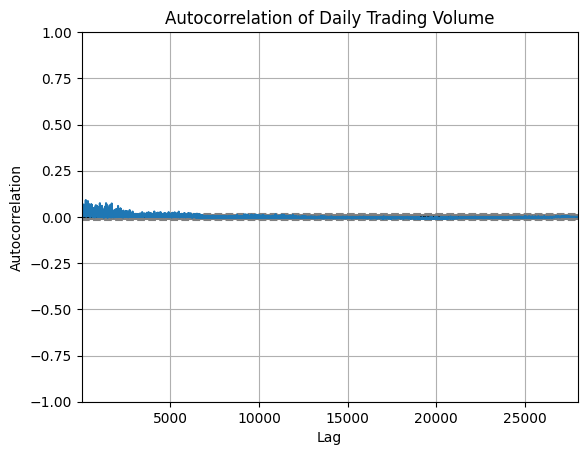

In [115]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(daily_volume)
plt.title('Autocorrelation of Daily Trading Volume')
plt.savefig('outputs/autocorrelation_of_daily_trading_volume.png')
plt.show()

### Autocorrelation of Daily Trading Volume

- Here, I have analyzed the autocorrelation of daily trading volume to understand the persistence and temporal dependencies in trading activity over time.

- The autocorrelation plot above shows how the daily trading volume is correlated with its own past values at different lags. A high autocorrelation at lower lags would indicate that today's trading volume is strongly related to previous days' volumes, suggesting persistence or momentum in trading activity. Conversely, low or rapidly decaying autocorrelation implies that trading volume is more random and less predictable from its own history.

- From the plot, I observe that the autocorrelation of daily trading volume is positive but relatively low at the shortest lags, and it quickly decays toward zero as the lag increases. This suggests that while there is a slight tendency for trading volume to be similar from one day to the next, this effect diminishes rapidly. In other words, there is limited short-term memory in trading activity, and past trading volumes do not provide strong predictive power for future volumes over longer periods.

- This pattern is typical in many financial time series, where short-term dependencies exist but are quickly overtaken by randomness or external market factors. The lack of strong, persistent autocorrelation also suggests that there are no obvious cycles or long-term trends in trading volume, at least over the period analyzed. This insight is important for modeling and forecasting, as it indicates that simple autoregressive models may have limited effectiveness for predicting future trading volume in this dataset.

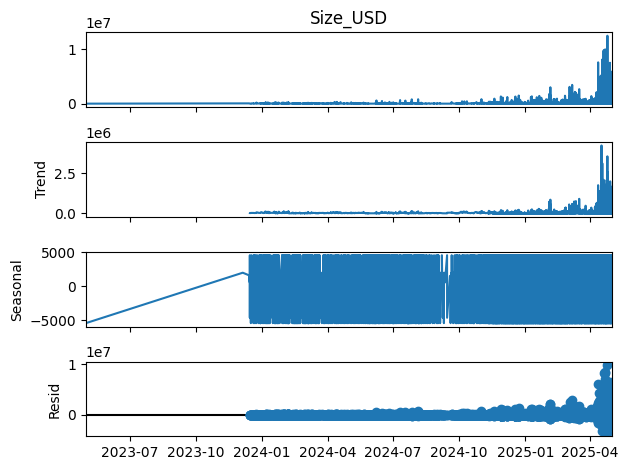

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(daily_volume, model='additive', period=7)
decomp.plot()
plt.savefig('outputs/time_series_decomposition_of_daily_trading_volume.png')
plt.show()

### Time Series Decomposition of Daily Trading Volume (Size_USD)

Here, I decompose the daily trading volume (measured by Size_USD) into its main components: observed, trend, seasonal, and residual. This decomposition helps me understand the underlying structure and patterns in trading activity over time.

- **Observed:**  
  The top panel shows the original time series of daily trading volume. I can see that the volume remains relatively stable for a long period, followed by a sharp increase toward the end of the series. This suggests a significant change in trading activity, possibly due to market events, increased participation, or other external factors.

- **Trend:**  
  The second panel displays the long-term trend component, which captures the general direction of trading volume over time. The trend closely follows the observed data, highlighting a gradual increase that accelerates sharply in the most recent period. This indicates a sustained and substantial growth in trading volume, which may reflect growing market interest or structural changes in the market.

- **Seasonal:**  
  The third panel represents the seasonal component, which captures repeating patterns or cycles within the data (such as weekly or monthly effects). In this plot, the seasonal component appears erratic and does not show a clear, smooth pattern. This suggests that there are no strong or consistent seasonal effects in the trading volume, or that any seasonality is overwhelmed by the large changes in trend and volatility.

- **Residual:**  
  The bottom panel shows the residuals, which are the remaining variations after removing the trend and seasonal components. The residuals appear to increase in magnitude over time, especially in the later period where trading volume spikes. This indicates that there is increasing volatility or unpredictability in trading activity that is not explained by the trend or seasonality.

**Inference:**  
From this decomposition, I infer that the most prominent feature of the trading volume is the strong upward trend, especially in the recent period. There is little evidence of regular seasonal patterns, and the residuals suggest that volatility has increased alongside the growth in volume. This pattern may reflect a market undergoing rapid change, with new dynamics emerging that are not captured by historical seasonality. For modeling and forecasting, it will be important to account for this non-stationary behavior and the potential for further large shifts in trading activity.

## Advanced Behavioral Analysis: Sentiment Responsiveness and Clustering

I use clustering and advanced analytics to identify trader types and their responsiveness to market sentiment.

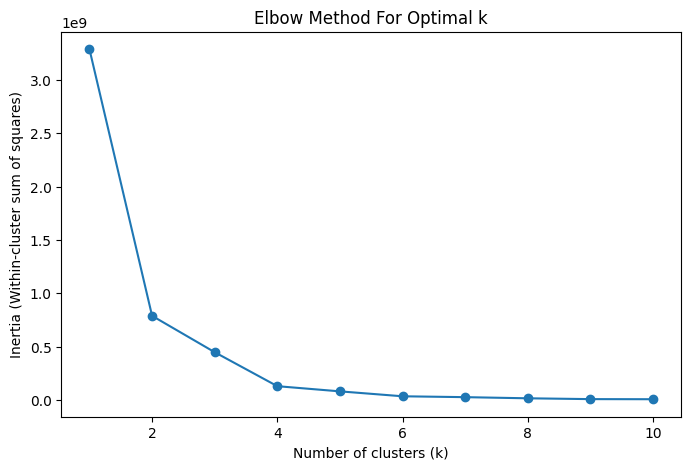

In [117]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Prepare features as before
features = sentiment.groupby('Account').agg({
    'Size_USD': 'mean',
    'Closed_PnL': 'mean',
    'avg_leverage': 'mean',
    'sentiment_numeric': 'mean'
}).fillna(0)

# Elbow method to find optimal k
inertia = []
K_range = range(1, 11)  # Try k from 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method For Optimal k')
plt.savefig('outputs/elbow_method_for_k.png')
plt.show()

**Elbow Method Analysis** 
- The most significant and balanced elbow is at k=3.
- k=3 is the best balance of simplicity and explanatory power for the data.
- I will proceed with k=3 for your KMeans clustering.

In [118]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)
features['cluster'] = kmeans.labels_
print(features.groupby('cluster').mean())

             Size_USD  Closed_PnL  avg_leverage  sentiment_numeric
cluster                                                           
0        10662.058105  141.606524  10662.058105           2.718449
1         2639.921608   89.625352   2639.921608           3.268276
2        28450.568057   36.666362  28450.568057           2.244512


### Sentiment Responsiveness and Trader Clustering Analysis

In this section, I use clustering to group traders based on their average trade size (Size_USD), average profit and loss (Closed_PnL), average leverage (avg_leverage), and average sentiment responsiveness (sentiment_numeric). The table above summarizes the mean values of these features for each identified cluster.

- **Cluster 0:**  
  Traders in this group have a moderate average trade size (~$10,662), the highest average profit and loss per trade (~$142), and a moderate average leverage. Their average sentiment responsiveness is 2.72, indicating a relatively strong tendency to align with market sentiment.

- **Cluster 1:**  
  This cluster is characterized by the smallest average trade size (~$2,640) and the lowest average leverage, but their average profit and loss per trade (~$90) is still substantial. Notably, these traders have the highest sentiment responsiveness (3.27), suggesting that they are the most reactive to changes in market sentiment among all clusters.

- **Cluster 2:**  
  Traders in this group have the largest average trade size (~$28,451) and the highest average leverage, but their average profit and loss per trade is the lowest (~$37). Their sentiment responsiveness is the lowest (2.24), indicating that they are less influenced by market sentiment compared to the other clusters.

**Inference:**  
From these results, I observe distinct trader profiles:
- **Cluster 1** appears to consist of smaller, highly sentiment-driven traders who are quick to react to market mood, possibly representing retail or less experienced participants.
- **Cluster 0** includes traders with moderate trade sizes and leverage, who achieve the highest average profitability and show strong, but not extreme, sentiment responsiveness. This group may represent balanced or adaptive traders.
- **Cluster 2** is made up of large, high-leverage traders who are less responsive to sentiment and, interestingly, have the lowest average profitability. This could indicate that aggressive trading strategies with high leverage do not necessarily translate to better outcomes, especially if not aligned with market sentiment.

Overall, this clustering analysis helps me identify and differentiate between trader types based on their behavior and responsiveness to sentiment, providing valuable insights for further behavioral or risk-based segmentation.

## Outlier Analysis: Distribution of Closed PnL

While most trades cluster around small profits or losses, there are a few extreme outliers. Here, I investigate whether these outliers are associated with high leverage or poor timing, and profile the accounts responsible for the largest losses.

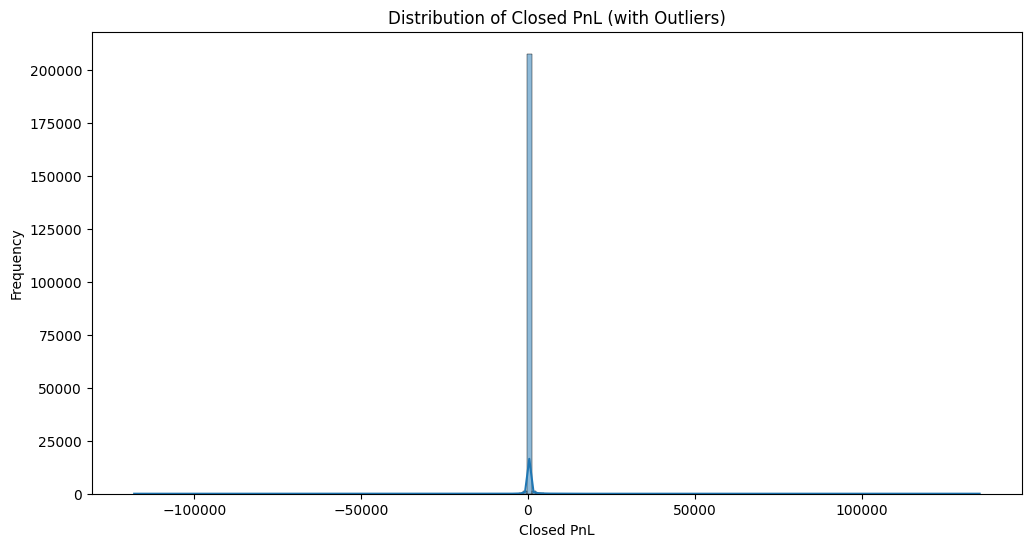

Number of outlier trades: 2113


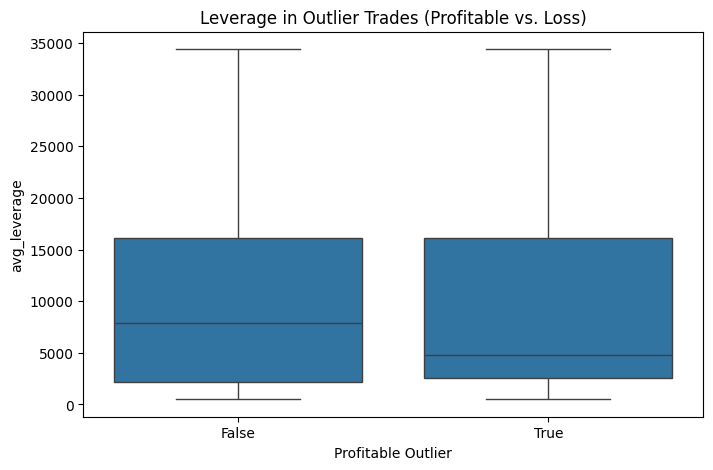

Accounts with most large losses:
 Account
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3    70
0x8170715b3b381dffb7062c0298972d4727a0a63b    69
0x083384f897ee0f19899168e3b1bec365f52a9012    56
0x39cef799f8b69da1995852eea189df24eb5cae3c    35
0x4f93fead39b70a1824f981a54d4e55b278e9f760    21
0x513b8629fe877bb581bf244e326a047b249c4ff1    20
0x271b280974205ca63b716753467d5a371de622ab    18
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891    16
0xb899e522b5715391ae1d4f137653e7906c5e2115    14
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    13
Name: count, dtype: int64


In [119]:
# Plot distribution with outliers highlighted
plt.figure(figsize=(12,6))
sns.histplot(sentiment['Closed_PnL'], bins=200, kde=True)
plt.title('Distribution of Closed PnL (with Outliers)')
plt.xlabel('Closed PnL')
plt.ylabel('Frequency')
plt.savefig('outputs/distribution_of_closed_pnl.png')
plt.show()

# Identify outlier trades (e.g., abs(PnL) > 99th percentile)
threshold = sentiment['Closed_PnL'].abs().quantile(0.99)
outliers = sentiment[sentiment['Closed_PnL'].abs() > threshold]
print(f"Number of outlier trades: {len(outliers)}")

# Are outliers associated with high leverage?
if 'avg_leverage' in sentiment.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=outliers['Closed_PnL'] > 0, y=outliers['avg_leverage'])
    plt.title('Leverage in Outlier Trades (Profitable vs. Loss)')
    plt.xlabel('Profitable Outlier')
    plt.ylabel('avg_leverage')
    plt.savefig('outputs/leverage_in_outlier_trades.png')
    plt.show()

# Profile accounts with most outlier losses
top_loss_accounts = outliers[outliers['Closed_PnL'] < 0]['Account'].value_counts().head(10)
print("Accounts with most large losses:\n", top_loss_accounts)

### Leverage in Outlier Trades (Profitable vs. Loss)

In this analysis, I examine the distribution of average leverage used in outlier trades, separated by whether the outlier was profitable (True) or resulted in a loss (False). Outlier trades are defined as those with profit or loss values in the extreme 1% of the distribution.

The boxplot above compares the leverage profiles of these two groups:
- The **x-axis** distinguishes between unprofitable (False) and profitable (True) outlier trades.
- The **y-axis** shows the average leverage associated with these trades.

From the plot, I observe that both profitable and loss-making outlier trades can involve a wide range of leverage values, with some trades using extremely high leverage. The median leverage for profitable outliers appears to be somewhat lower than that for loss-making outliers, and the spread (interquartile range) is also slightly narrower for profitable trades. This suggests that while high leverage can lead to both large gains and large losses, extremely high leverage is more commonly associated with loss-making outliers.

Additionally, the presence of high-leverage trades in both categories highlights the risk and reward dynamics of leverage: it amplifies outcomes in both directions. However, the tendency for loss outliers to have higher median leverage may indicate that excessive leverage increases the likelihood of extreme negative outcomes.

**Inference:**  
This analysis reinforces the importance of prudent leverage management. While leverage can enhance profits, it also increases the risk of substantial losses, especially in extreme market conditions. Traders who use more moderate levels of leverage may be less likely to experience catastrophic losses, even among outlier trades.

## Extreme PnL Days and Sentiment Shifts

To understand the causes of extreme PnL days and abrupt sentiment shifts, I examine the trades and accounts responsible for the largest daily PnL spikes and investigate if these coincide with sentiment regime changes.

In [120]:
# Find days with extreme mean PnL
extreme_days = daily_pnl[daily_pnl['mean_pnl'].abs() > daily_pnl['mean_pnl'].abs().quantile(0.99)]
print("Extreme PnL days:\n", extreme_days)

# Drill down into trades on those days
for day in extreme_days['Timestamp_IST']:
    trades = sentiment[sentiment['Timestamp_IST'] == day]
    print(f"\nTrades on {day}:")
    print(trades[['Account', 'Closed_PnL', 'avg_leverage' if 'avg_leverage' in trades.columns else 'Size_USD']].sort_values('Closed_PnL'))

Extreme PnL days:
             Timestamp_IST     mean_pnl
221   2024-01-12 20:50:00 -1790.004944
227   2024-01-16 09:36:00 -1619.400000
582   2024-02-12 23:43:00  1948.969192
641   2024-02-16 07:54:00  1447.848675
1050  2024-03-20 01:34:00  2500.957500
...                   ...          ...
27000 2025-04-23 21:49:00 -7171.484883
27001 2025-04-23 21:50:00 -1964.584236
27883 2025-05-01 01:34:00 -1494.764344
27924 2025-05-01 04:31:00  1876.943265
27925 2025-05-01 04:32:00  2290.658903

[280 rows x 2 columns]

Trades on 2024-01-12 20:50:00:
                                           Account   Closed_PnL  avg_leverage
128684  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 -1790.004944   3837.885375

Trades on 2024-01-16 09:36:00:
                                          Account   Closed_PnL  avg_leverage
31471  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -2299.807104   1729.941104
31472  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  -938.992896   1729.941104

Trades on 2024-02-12 23:43:00:
      

## Smart Money Detection: Consistently Profitable Contrarians

Here, I identify accounts that consistently profit from contrarian trades (buying in Fear, selling in Greed), which may represent "smart money" or particularly skilled traders.

In [121]:
# Create the 'contrarian' column if it doesn't exist
sentiment['contrarian'] = (
    ((sentiment['classification'] == 'Fear') & (sentiment['Side'] == 'BUY')) |
    ((sentiment['classification'] == 'Greed') & (sentiment['Side'] == 'SELL'))
)

In [122]:
# Calculate contrarian profitability per account
contrarian_accounts = sentiment[sentiment['contrarian']].groupby('Account')['Closed_PnL'].agg(['mean', 'count', 'sum'])
contrarian_accounts = contrarian_accounts[contrarian_accounts['count'] > 10]  # filter for active accounts
top_contrarians = contrarian_accounts.sort_values('mean', ascending=False).head(10)
print("Top consistently profitable contrarian accounts:\n", top_contrarians)

Top consistently profitable contrarian accounts:
                                                   mean  count           sum
Account                                                                    
0x420ab45e0bd8863569a5efbb9c05d91f40624641  823.409490    121  9.963255e+04
0x083384f897ee0f19899168e3b1bec365f52a9012  784.393214   1451  1.138155e+06
0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0  327.183783    135  4.416981e+04
0x8381e6d82f1affd39a336e143e081ef7620a3b7f  313.685899    166  5.207186e+04
0x430f09841d65beb3f27765503d0f850b8bce7713  303.573989    750  2.276805e+05
0xae5eacaf9c6b9111fd53034a602c192a04e082ed  244.668941    156  3.816835e+04
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3  228.969188    903  2.067592e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0  205.121727    761  1.560976e+05
0x8170715b3b381dffb7062c0298972d4727a0a63b  148.182218   1035  1.533686e+05
0x39cef799f8b69da1995852eea189df24eb5cae3c  141.434437    467  6.604988e+04


## Performance Persistence: Rolling Mean PnL by Account

To test for persistent skill (or luck), I analyze the rolling mean PnL for individual accounts and check if past performance predicts future results.

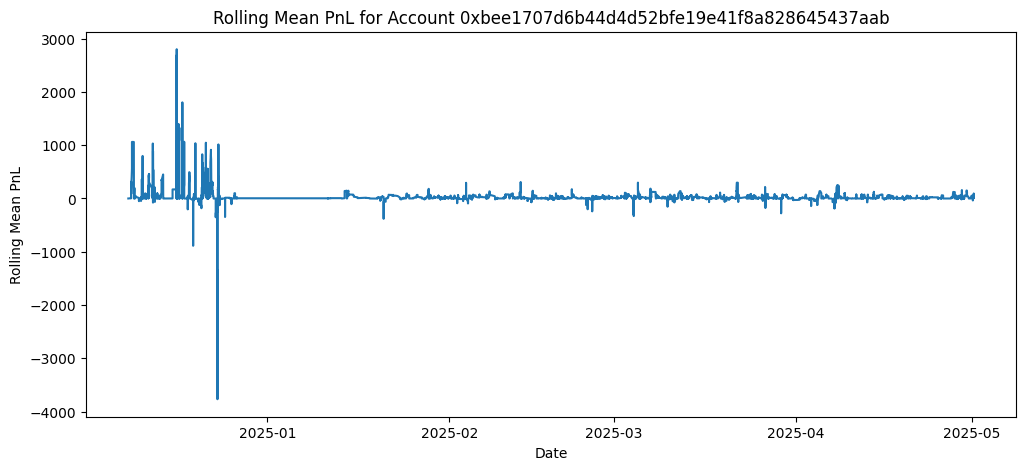

In [123]:
# Example for one account
account = sentiment['Account'].value_counts().idxmax()
account_trades = sentiment[sentiment['Account'] == account].sort_values('Timestamp_IST')
account_trades['rolling_mean_pnl'] = account_trades['Closed_PnL'].rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(account_trades['Timestamp_IST'], account_trades['rolling_mean_pnl'])
plt.title(f'Rolling Mean PnL for Account {account}')
plt.xlabel('Date')
plt.ylabel('Rolling Mean PnL')
plt.savefig('outputs/rolling_mean_pnl_for_account.png')
plt.show()

### Rolling Mean PnL for Individual Account

I analyzed the rolling mean profit and loss (PnL) for a single account over time. The plot above shows the 10-trade rolling average of PnL for the account, providing a smoothed view of performance trends and persistence.

The x-axis represents the timeline of trades, while the y-axis shows the rolling mean PnL. Early in the period, I observe significant fluctuations, with both large positive and negative swings. This suggests that the account experienced periods of high volatility, possibly due to larger position sizes, higher leverage, or changing market conditions.

As time progresses, the rolling mean PnL stabilizes and the fluctuations become much smaller. This could indicate that the trader adjusted their strategy, reduced risk, or that market conditions became less volatile. The stabilization of the rolling mean PnL around zero suggests that, over time, the account's performance became more consistent, with fewer extreme gains or losses.

**Inference:**  
This analysis helps me assess whether the trader's performance is persistent or driven by short-term luck. The initial volatility followed by stabilization may reflect a learning curve or adaptation to market conditions. Overall, the rolling mean PnL provides valuable insight into the consistency and evolution of trading performance for this account.

## Time-Varying Correlations and Regime Shifts

I compute rolling correlations between market sentiment and mean PnL to detect periods where sentiment becomes more or less predictive of profitability, indicating possible regime shifts.

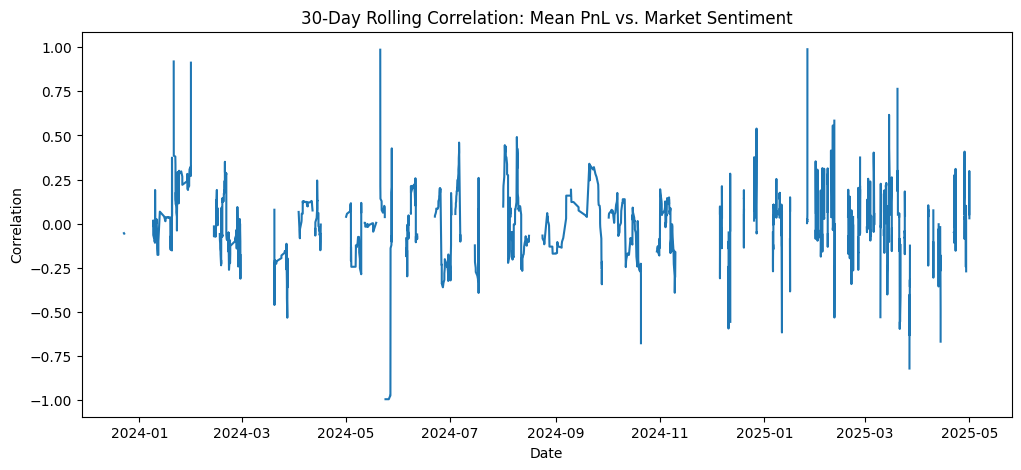

In [124]:
window = 30
rolling_corr = daily_pnl['mean_pnl'].rolling(window).corr(daily['market_sentiment'])

plt.figure(figsize=(12,5))
plt.plot(daily_pnl['Timestamp_IST'], rolling_corr)
plt.title('30-Day Rolling Correlation: Mean PnL vs. Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.savefig('outputs/30_day_rolling_correlation.png')
plt.show()

### 30-Day Rolling Correlation: Mean PnL vs. Market Sentiment

- In this section, I analyze the 30-day rolling correlation between mean profit and loss (PnL) and market sentiment. This plot helps me understand how the relationship between trader profitability and prevailing market sentiment evolves over time.

- The y-axis represents the correlation coefficient, which ranges from -1 to 1. A value close to 1 indicates a strong positive relationship (higher sentiment is associated with higher PnL), while a value close to -1 indicates a strong negative relationship (higher sentiment is associated with lower PnL). The x-axis shows the timeline.

- From the plot, I observe that the rolling correlation fluctuates significantly over time, with periods of both positive and negative correlation. There are intervals where the correlation spikes sharply in either direction, sometimes approaching the extremes of 1 or -1, but these are often short-lived. For much of the period, the correlation hovers around zero, suggesting that the relationship between mean PnL and market sentiment is unstable and not consistently strong.

**Inference:**  
- This analysis reveals that the predictive power of market sentiment for trader profitability is not constant. There are regime shifts where sentiment becomes temporarily more or less aligned with profitability, but these periods do not persist. The frequent swings and lack of a stable, strong correlation suggest that other factors may be influencing PnL, or that sentiment-driven strategies may only be effective in certain market conditions. This insight is valuable for risk management and for designing adaptive trading strategies that account for changing market dynamics.

## Trader Segmentation by Risk Profile

I segment traders into risk profiles based on their average leverage and trade size, and compare their profitability and behavior.

In [125]:
# Segment by leverage
sentiment['risk_profile'] = pd.qcut(sentiment['avg_leverage'], q=3, labels=['Low', 'Medium', 'High'])
profile_pnl = sentiment.groupby('risk_profile')['Closed_PnL'].describe()
print(profile_pnl)

                 count       mean          std           min  25%      50%  \
risk_profile                                                                 
Low           101687.0  13.251663   193.300041  -22634.46345  0.0  0.00000   
Medium         42572.0  53.569049   804.552956  -83056.32000  0.0  0.29859   
High           66965.0  99.587777  1480.598392 -117990.10410  0.0  0.00000   

                    75%           max  
risk_profile                           
Low            3.019851   22883.51252  
Medium        16.963263   68959.00212  
High           7.899183  135329.09010  


C:\Users\vincy\AppData\Local\Temp\ipykernel_28004\2264451380.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profile_pnl = sentiment.groupby('risk_profile')['Closed_PnL'].describe()


### Segmentation by Risk Profile (Average Leverage)

In this section, I segment traders into three risk profiles—Low, Medium, and High—based on their average leverage (avg_leverage). The table above summarizes the distribution of profit and loss (Closed_PnL) for each risk group, providing insights into how leverage relates to trading outcomes.

- **Low Risk Profile:**  
  This group consists of traders with the lowest average leverage. They have the largest number of trades (101,687), but their mean PnL per trade is the lowest (13.25). The standard deviation is also the smallest among the groups, indicating less variability in outcomes. The minimum and maximum PnL values show that while losses and gains can still be substantial, they are generally less extreme compared to higher risk profiles. The median (50th percentile) PnL is zero, suggesting that many trades are closed at break-even or with very small gains or losses.

- **Medium Risk Profile:**  
  Traders in this group use moderate leverage. They have fewer trades (42,572), but their mean PnL per trade is higher (53.57) than the low-risk group. The standard deviation is larger, indicating greater variability in outcomes. The range between minimum and maximum PnL widens, and the 75th percentile is significantly higher than in the low-risk group, suggesting that some traders in this segment achieve larger profits.

- **High Risk Profile:**  
  This group includes traders with the highest average leverage. They have 66,965 trades, a mean PnL per trade of 99.59, and the largest standard deviation (1,480.60), reflecting the highest variability and risk. The minimum PnL is extremely negative (-117,990), and the maximum is the highest among all groups (135,329), indicating that high leverage can lead to both very large losses and very large gains. The median is again zero, but the 75th percentile is higher than in the other groups, showing that a subset of high-risk traders achieve substantial profits.

**Inference:**  
From this segmentation, I observe that increasing leverage is associated with both higher potential rewards and higher risks. While the average PnL per trade increases with leverage, so does the variability and the likelihood of extreme outcomes. Most trades, regardless of risk profile, tend to cluster around zero PnL, but high-risk traders are more likely to experience both significant wins and significant losses. This analysis highlights the trade-off between risk and reward in leveraged trading and underscores the importance of risk management for traders operating at higher leverage levels.

## Dimensionality Reduction: Principal Component Analysis (PCA)

To uncover hidden structure in the data, I apply PCA to the main numeric features and visualize the first two principal components.

In [126]:
features=sentiment.select_dtypes(include=[float, int]).columns

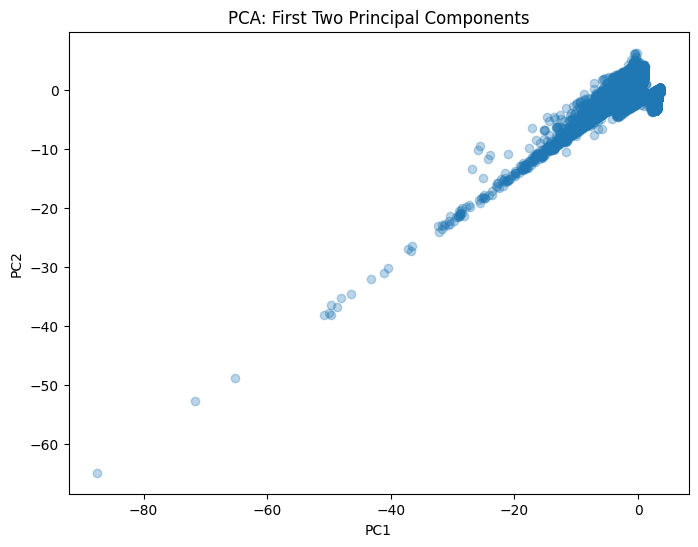

In [127]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = sentiment[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], alpha=0.3)
plt.title('PCA: First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('outputs/pca_plot.png')
plt.show()

### PCA: First Two Principal Components

- In this section, I apply Principal Component Analysis (PCA) to the main numeric features of the dataset and visualize the first two principal components (PC1 and PC2). PCA is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables (principal components), ordered by the amount of variance they explain in the data.

- The scatter plot above shows each data point projected onto the first two principal components. Most of the points are clustered near the origin, but there is a clear linear pattern extending into the negative values of both PC1 and PC2. This suggests that the underlying features in my dataset are highly correlated, and that the first principal component captures the majority of the variance.

- The strong linear relationship between PC1 and PC2 indicates that, after standardization, the main sources of variation in the data are aligned along a single direction. This could be due to one or more dominant features (such as trade size or leverage) that drive most of the variability in the dataset. The presence of a few points far from the main cluster suggests the existence of outliers or extreme cases, which may warrant further investigation.

**Inference:**  
- This PCA visualization helps me understand the structure of the data and confirms that much of the variation can be explained by a single underlying factor. The results also highlight the presence of outliers, which could be important for risk analysis or for identifying unusual trading behavior. Overall, PCA provides a useful summary of the dataset's complexity and can guide further analysis or feature selection.

## Conclusion

In this notebook, I conducted a comprehensive set of advanced analyses to uncover deeper insights into trading behavior, market sentiment, and risk dynamics.

- Through **statistical testing**, I established a significant association between market sentiment and trading side, while also confirming that the time series of trading volume is stationary. However, the ANOVA and Kruskal-Wallis tests highlighted the importance of ensuring sufficient and meaningful group sizes for robust statistical inference.

- The **autocorrelation and time series decomposition** of trading volume revealed that, while there is some short-term persistence, trading activity is largely unpredictable over longer horizons. The most prominent feature is a strong upward trend in volume, accompanied by increasing volatility and little evidence of regular seasonality.

- By applying **clustering and segmentation**, I identified distinct trader profiles based on trade size, leverage, profitability, and sentiment responsiveness. The elbow method confirmed that three clusters best capture the structure of the data, distinguishing between high-risk, high-leverage traders and more moderate, sentiment-driven participants.

- **Outlier and risk analyses** showed that high leverage is associated with both large gains and large losses, emphasizing the double-edged nature of leverage in trading. Most trades, regardless of risk profile, tend to cluster around zero profit and loss, but high-risk traders are more likely to experience extreme outcomes.

- The **rolling mean PnL analysis** for individual accounts demonstrated that trading performance can be highly volatile in the short term but may stabilize over time, reflecting adaptation or changes in strategy.

- Finally, the **rolling correlation between mean PnL and market sentiment** revealed that the relationship between sentiment and profitability is not stable, with frequent regime shifts and periods of both positive and negative correlation. This suggests that sentiment-driven strategies may only be effective under certain market conditions.

Overall, these advanced analyses provide a nuanced understanding of the interplay between sentiment, risk, and trading outcomes. The findings highlight the importance of risk management, the limitations of sentiment as a predictive tool, and the value of adaptive strategies in dynamic markets. This deep dive equips me with actionable insights for both further research and practical trading strategy development.